# This notebook computes the Fisher matrix for the 7 parameter secondary 21-cm trispectrum + primordial trispectra as a function of $k_{\rm max}$

## this notebook uses the normal parametrization that is good for computing the $g_{\rm NL}^{\rm loc}$, equilateral and clock shapes

In [1]:
import numpy as np
from numba import njit
from secondaryTrispectrum import *
from trispectra import *
import matplotlib.pyplot as plt
from scipy import interpolate
import vegas
from joblib import Parallel, delayed
%matplotlib inline
plt.rcParams.update({'font.size': 12})
n_jobs=-1 #number of threads

In [2]:
zs,rs = np.genfromtxt("comovingD.dat").T
znmids = np.arange(1,len(zs),2)

VzTotal = 4.*np.pi/3. * (rs[-1]**3-rs[0]**3)

Vzs = np.array([4.*np.pi/3. * (rs[i+1]**3-rs[i-1]**3) for i in znmids])

In [4]:
Vzs

array([3.48501648e+11, 2.91473844e+11, 2.48641202e+11, 2.15475867e+11,
       1.89157544e+11, 1.67845983e+11, 1.50293756e+11, 1.35627941e+11,
       1.23220979e+11, 1.12611139e+11, 1.03451799e+11, 9.54781287e+10,
       8.84846143e+10, 8.23095515e+10])

(232, 30)


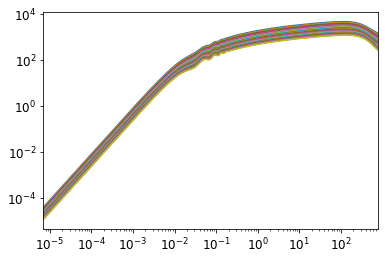

In [3]:
transferdata = np.genfromtxt("BaryonTransfer-z100-z30-delta05.dat")
kTF = transferdata[:,0]
print(transferdata.shape)
TFdata = np.flip(transferdata[:,1:],axis=1)
plt.loglog(kTF,TFdata)
plt.xlim(kTF[0],kTF[-1])
plt.show()
TFint = interpolate.interp1d(kTF,TFdata[:,znmids],axis=0,bounds_error=False)

In [5]:
dataT21 = np.genfromtxt("T21.dat")
dataCoef = np.genfromtxt("alphacoeffdata.dat")

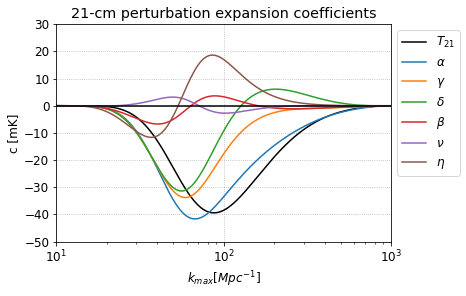

In [6]:
names = ['$T_{21}$','$\\alpha$','$\\gamma$','$\\delta$','$\\beta$','$\\nu$','$\\eta$']
plt.semilogx(dataT21[:,0],dataT21[:,1],'-k',label=names[0])
[plt.semilogx(dataCoef[:,0],dataCoef[:,n],label=names[n]) for n in range(1,dataCoef.shape[1])]
plt.gca().set_prop_cycle(None)
plt.semilogx([10,1000],[0,0],'-k')
plt.xlim(10,1000)
plt.grid(linestyle=":")
plt.xlabel("$k_{max} [Mpc^{-1}]$")
plt.ylabel("c [mK]")
plt.title("21-cm perturbation expansion coefficients")
plt.ylim(-50,30)
plt.legend(bbox_to_anchor=(1,1))
plt.show()

In [7]:
T21zs = dataT21[:,0]
Coefzs = dataCoef[:,0]

T21s = dataT21[:,1]
alphas = dataCoef[:,1]
betas  = dataCoef[:,4]
gammas = dataCoef[:,2]
deltas = dataCoef[:,3]
nus    = dataCoef[:,5]
etas   = dataCoef[:,6]

## Set up the integral for the Fisher matrix elements

In [9]:
def integrand(k,kmin,kmax,S1,S2,fn,munu,T21,alpha,beta,gamma,delta,eta,nu):
    # print(k.shape)
    Fish = np.zeros((len(k),14))

    k1max = kmax
    k1p = k1max*k[:,0]
    k1zmax = np.sqrt(k1max**2 - k1p**2)
    k1z = k1zmax*k[:,1]
    k1 = np.sqrt(k1p**2 + k1z**2)

    k2max = kmax
    k2p = k2max*k[:,2]
    k2zmax = np.sqrt(k2max**2 - k2p**2)
    k2z = k2zmax*k[:,3]
    k2= np.sqrt(k2p**2 + k2z**2)

    k3max = kmax
    k3p = k3max*k[:,4]
    k3zmax = np.sqrt(k3max**2 - k3p**2)
    k3z = k3zmax*k[:,5]
    k3 = np.sqrt(k3p**2 + k3z**2)

    phi2 = k[:,6]
    phi3 = k[:,7]
    
    k4p = np.sqrt(k1p**2 + k2p**2 + k3p**2 + 2*k1p*k2p*np.cos(phi2) + 2*k1p*k3p*np.cos(phi3) + 2*k3p*k2p*np.cos(phi2-phi3))
    k4z = -k1z-k2z-k3z
    k4 = np.sqrt(k4p**2 + k4z**2)

    K12p = np.sqrt(k1p**2 + k2p**2 + 2*k1p*k2p*np.cos(phi2))
    K12z = k1z+k2z
    K12 = np.sqrt(K12p**2 + K12z**2)

    K13p = np.sqrt(k1p**2 + k3p**2 + 2*k1p*k3p*np.cos(phi3))
    K13z = k1z+k3z
    K13 = np.sqrt(K13p**2 + K13z**2)

    K14p = np.sqrt(k2p**2 + k3p**2 + 2*k2p*k3p*np.cos(phi2-phi3))
    K14z = k1z+k4z
    K14 = np.sqrt(K14p**2 + K14z**2)

    dVol = 2*np.pi * k1p * k2p * k3p * k1max * k2max * k3max * k1zmax * k2zmax * k3zmax # 2pi comes from angular integration of phi1
    
    bools = k1 < kmax
    bools*= k1 > kmin
    bools*= k2 < k1
    bools*= k2 > kmin
    bools*= k3 < k2
    bools*= k3 > kmin
    bools*= k4 < kmax
    bools*= k4 > kmin
    bools*= K12 > kmin
    bools*= K13 > kmin
    bools*= K14 > kmin
    bools*= K12 < 2*kmax
    bools*= K13 < 2*kmax
    bools*= K14 < 2*kmax
    bools*= np.abs(k1z) > kmin
    bools*= np.abs(k2z) > kmin
    bools*= np.abs(k3z) > kmin
    bools*= np.abs(k4z) > kmin

    k1 = k1[bools]
    k1z = k1z[bools]
    k2 = k2[bools]
    k2z = k2z[bools]
    k3 = k3[bools]
    k3z = k3z[bools]
    k4 = k4[bools]
    k4z = k4z[bools]
    K12 = K12[bools]
    K12z = K12z[bools]
    K13 = K13[bools]
    K13z = K13z[bools]
    K14 = K14[bools]
    K14z = K14z[bools]

    mu1 = ((k1z/k1)**2)[:,np.newaxis]
    mu2 = ((k2z/k2)**2)[:,np.newaxis]
    mu3 = ((k3z/k3)**2)[:,np.newaxis]
    mu4 = ((k4z/k4)**2)[:,np.newaxis]
    mu12 = ((K12z/K12)**2)[:,np.newaxis]
    mu13 = ((K13z/K13)**2)[:,np.newaxis]
    mu14 = ((K14z/K14)**2)[:,np.newaxis]

    TF1     = TFint(k1)
    TF2     = TFint(k2)
    TF3     = TFint(k3)
    TF4     = TFint(k4)
    TF12    = TFint(K12)
    TF13    = TFint(K13)
    TF14    = TFint(K14)

    k1 = k1[:,np.newaxis]
    k2 = k2[:,np.newaxis]
    k3 = k3[:,np.newaxis]
    k4 = k4[:,np.newaxis]
    K12 = K12[:,np.newaxis]
    K13 = K13[:,np.newaxis]
    K14 = K14[:,np.newaxis]
    
    P1prim = P(k1)
    P2prim = P(k2)
    P3prim = P(k3)
    P4prim = P(k4)
    P12prim = P(K12)
    P13prim = P(K13)
    P14prim = P(K14)

    P1 = TF1**2 * P1prim
    P2 = TF2**2 * P2prim
    P3 = TF3**2 * P3prim
    P4 = TF4**2 * P4prim
    P12 = TF12**2 * P12prim
    P13 = TF13**2 * P13prim
    P14 = TF14**2 * P14prim

    pre1 = alpha + T21 * mu1
    pre2 = alpha + T21 * mu2
    pre3 = alpha + T21 * mu3
    pre4 = alpha + T21 * mu4

    P1T = pre1**2 * P1
    P2T = pre2**2 * P2
    P3T = pre3**2 * P3
    P4T = pre4**2 * P4

    # print(k1.shape,mu1.shape,P1.shape)

    if S1 < 7:
        c1 = Secondary7(S1,k1,k2,k3,k4,K12,K13,K14,mu1,mu2,mu3,mu4,mu12,mu13,mu14,P1,P2,P3,P4,P12,P13,P14,T21,alpha,beta,gamma,delta,eta,nu) ## gives back all permutations already
    if S1 == 7:
        c1 = pre1*pre2*pre3*pre4*TF1*TF2*TF3*TF4*fn(k1,k2,k3,k4,K12,K14,K13,munu) ## note the different ordering of K13 and K14 compared to secondary...

    if S2 == S1:
        c2 = c1
    elif S2 < 7:
        c2 = Secondary7(S2,k1,k2,k3,k4,K12,K13,K14,mu1,mu2,mu3,mu4,mu12,mu13,mu14,P1,P2,P3,P4,P12,P13,P14,T21,alpha,beta,gamma,delta,eta,nu)
    elif S2 == 7:
        c2 = pre1*pre2*pre3*pre4*TF1*TF2*TF3*TF4*fn(k1,k2,k3,k4,K12,K14,K13,munu)

    Fish[bools] = c1*c2 / P1T/P2T/P3T/P4T 
    Fish *= Vzs[np.newaxis,:]
    
    result = np.sum(Fish,axis=1)/4 /(2*np.pi)**9 * dVol
    return result

def Fisher(kmin,kmax,S1,S2,fn,munu,rtol):
    integ = vegas.Integrator([[0,1],[-1,1],[0,1],[-1,1],[0,1],[-1,1],[0,2*np.pi],[0,2*np.pi]])
    zmids = zs[znmids]
    T21 = np.interp(zmids,T21zs,T21s)[np.newaxis,:]
    alpha = np.interp(zmids,Coefzs,alphas)[np.newaxis,:]
    beta = np.interp(zmids,Coefzs,betas)[np.newaxis,:]
    gamma = np.interp(zmids,Coefzs,gammas)[np.newaxis,:]
    delta = np.interp(zmids,Coefzs,deltas)[np.newaxis,:]
    eta = np.interp(zmids,Coefzs,etas)[np.newaxis,:]
    nu = np.interp(zmids,Coefzs,nus)[np.newaxis,:]
    # print(z,T21,alpha,beta,gamma,delta,eta,nu)

    @vegas.batchintegrand
    def integrandbatch(k):
        return integrand(k,kmin,kmax,S1,S2,fn,munu,T21,alpha,beta,gamma,delta,eta,nu)

    pre = integ(integrandbatch,nitn=10,neval=1e6,rtol=rtol)
    print(pre.summary())

    results = integ(integrandbatch,nitn=100,neval=1e6,rtol=rtol)
    print(results.summary())
    mean = results.mean
    rerr = np.abs(results.sdev/mean)
    
    print(S1,S2,mean,rerr)
    return kmax, S1, S2, mean, rerr

## Compute row/column for different primordial trispectra x secondary trispectra

In [ ]:
ks = [0.3,1,3,10,30,100,300]
shapes = [Teq1,Teq2,Teq3,TgNL,TtauNL]
for shape in shapes:
    tasks = [delayed(Fisher)(0.01,km,S1,7,shape,0,0.001) for km in ks for S1 in range(8)]
    print(len(tasks),'tasks')
    tasks=tasks[::-1]
    data = np.array(Parallel(n_jobs=-1,verbose=10)(tasks))
    data = data[::-1]
    np.savetxt(f"Secondaries7ks{shape}.dat",data)